In [4]:
import pandas as pd
from DS_Helpers.filters import column_filter
from DS_Helpers.data import other_generator_columns, find_embed_object_cols, get_days_to_nearest_holiday
from DS_Helpers.metrics import classification_result
from DS_Helpers.models import simple_preprocessing, log_scaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [8]:
pipe = make_pipeline( simple_preprocessing
                     , StandardScaler()
                     , log_scaler 
                     , RandomForestClassifier(n_estimators=200
                                              , n_jobs=-1))


class pred_pipe:

    def __init__(self
                 , leads= 'data/leads_dataset.csv'
                 , infutor_enrichment_dataset ='data/infutor_enrichment_dataset.csv'
                 , zip_code_dataset='data/zip_code_dataset.csv'
                 , country_code='US'   ):
        
        leads = column_filter(pd.read_csv(leads), tolerance=0.4)
        leads.LEAD_CREATED_AT_UTC = pd.to_datetime(leads.LEAD_CREATED_AT_UTC)
        self.leads = leads


        self.infutor_enrichment_dataset = column_filter(pd.read_csv(infutor_enrichment_dataset, index_col=0), tolerance=0.4)
        self.zip_code_dataset = column_filter(pd.read_csv(zip_code_dataset), tolerance=0.3)


        self.data = pd.merge(left=self.leads
                             , right=self.infutor_enrichment_dataset
                             , on='HASHED_PHONE_NUMBER'
                             , how='left')
        
        self.data = pd.merge(left=self.data
                             , right=self.zip_code_dataset
                             , on='ZIP_CODE'
                             , how='left')
    
        
        self.infutor_enrichment_dataset = column_filter(pd.read_csv('data/infutor_enrichment_dataset.csv', index_col=0), tolerance=0.4)
        self.zip_code_dataset = column_filter(pd.read_csv('data/zip_code_dataset.csv'), tolerance=0.3)



        self.data = pd.merge(left=self.data
                             , right=self.zip_code_dataset
                             , on='ZIP_CODE'
                             , how='left')
        
        print('Generating Holiday Distance. Please wait this could take up to a few mminutes')
        self.data['days_to_holiday'] = self.data['LEAD_CREATED_AT_UTC'].apply(lambda x: get_days_to_nearest_holiday(x, country_code=country_code) if pd.notnull(x) else None)
        print('Holiday Distance Created!')

        
        self.data = self.data[ ~self.data.IS_APPOINTMENT_SET.isna() ]
        self.data = self.data.drop( labels='HASHED_PHONE_NUMBER ZIP_CODE'.split(), axis=1 )


    def train_test_split(self, test_size=0.3, random_state=42, embedding_dims=8):
        
        y = self.data.IS_APPOINTMENT_SET
        X = self.data.drop(labels='IS_APPOINTMENT_SET', axis=1)

        X['Year'] = X.LEAD_CREATED_AT_UTC.dt.year
        X['Month'] = X.LEAD_CREATED_AT_UTC.dt.month.astype('str')
        X['Weekday'] = X.LEAD_CREATED_AT_UTC.dt.weekday.astype('str')
        X['Day'] = X.LEAD_CREATED_AT_UTC.dt.day.astype('str')
        X['Hour'] = X.LEAD_CREATED_AT_UTC.dt.hour.astype('str')
        X = X.drop(labels='LEAD_CREATED_AT_UTC',axis=1)


        self.X, self.y = X, y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X
                                                                                , self.y
                                                                                , test_size=test_size
                                                                                , random_state=random_state)
        

        self.X_train = other_generator_columns(df=self.X_train, other_threshold=50)

        self.X_test = other_generator_columns(df=self.X_test, other_threshold=50)


        self.obj_embed = find_embed_object_cols(df=self.X_train, embedding_dims=embedding_dims)

        self.X_train_embed = self.obj_embed['df']



        self.X_test_embeding = self.X_test.copy()

        embedings = self.obj_embed['embedings']

        for key in embedings.keys():

            embeding_df = embedings[key].transform( self.X_test_embeding[key] )
            embeding_df.index = self.X_test_embeding.index
            self.X_test_embeding = pd.concat( objs=[self.X_test_embeding, embeding_df], axis=1 )
            self.X_test_embeding = self.X_test_embeding.drop(labels=key, axis=1)


    def train(self, pipe=pipe):

        self.pipe = pipe

        self.pipe.fit(self.X_train_embed, self.y_train.astype(str))

        

    def evaluate_model(self):
        probs = self.pipe.predict_proba(self.X_test_embeding)

        result = precision_recall_curve(
                                y_true=self.y_test.astype(int).values
                                ,  probas_pred=probs[:,1])

        plt.plot(result[0], result[1])

    def evaluate_model_metrics(self):

        self.y_pred = self.pipe.predict(self.X_test_embeding)
        classification_result(y_true=self.y_test.astype(str), y_pred=self.y_pred)

In [9]:
test = pred_pipe()

Generating Holiday Distance. Please wait this could take up to a few mminutes
Holiday Distance Created!


In [10]:
test.data.head()

,IS_APPOINTMENT_SET,LEAD_CREATED_AT_UTC,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,...,Drow Ranger_y,Earth Spirit_y,Earthshaker_y,Elder Titan_y,Ember Spirit_y,Enchantress_y,Enigma_y,Faceless Void_y,Pudge_y,days_to_holiday
0,True,2023-07-18 15:11:55+00:00,South Beloit,IL,Winnebago,gmail.com,Mobile,Android,Chrome Webview,114,...,1244.0,7.0,10.0,13.0,4.0,71.0,87.0,3.0,1984.0,14.0
1,False,2022-09-19 18:37:21+00:00,Cape Coral,FL,Lee,gmail.com,Mobile,iOS,UIWebView,605,...,2845.0,9.0,8.0,15.0,6.0,78.0,83.0,3.0,1998.0,14.0
2,True,2022-11-09 21:38:10+00:00,Kuttawa,KY,Lyon,gmail.com,Mobile,Android,Chrome Webview,105,...,1098.0,16.0,6.0,31.0,12.0,91.0,60.0,0.0,1981.0,2.0
3,False,2022-11-13 15:41:31+00:00,Zanesville,OH,Muskingum,gmail.com,Mobile,iOS,UIWebView,605,...,1140.0,20.0,18.0,33.0,23.0,63.0,72.0,4.0,1964.0,2.0
4,False,2022-10-07 17:56:51+00:00,Arlington,VA,Arlington,gmail.com,Mobile,iOS,UIWebView,605,...,4375.0,4.0,3.0,4.0,2.0,55.0,45.0,1.0,1948.0,3.0


In [11]:
test.train_test_split()

CITY
STATE
COUNTY
EMAIL_DOMAIN
OPERATINGSYSTEMCLASS
OPERATINGSYSTEMNAME
AGENTNAME
AGENTVERSIONMAJOR
DEVICEBRAND
DEVICENAME
LAYOUTENGINENAME
NETWORKTYPE
OPERATINGSYSTEMVERSIONMAJOR
WEBVIEWAPPNAME
ATTRIBUTES_COREDEMOGRAPHICS_GENDER
ATTRIBUTES_COREDEMOGRAPHICS_MARRIEDCD
ATTRIBUTES_COREDEMOGRAPHICS_WEALTHSCR
ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD
ATTRIBUTES_COREDEMOGRAPHICS_EHI
ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CREDITCARD
Month
Weekday
Day
Hour


In [12]:
test.train()

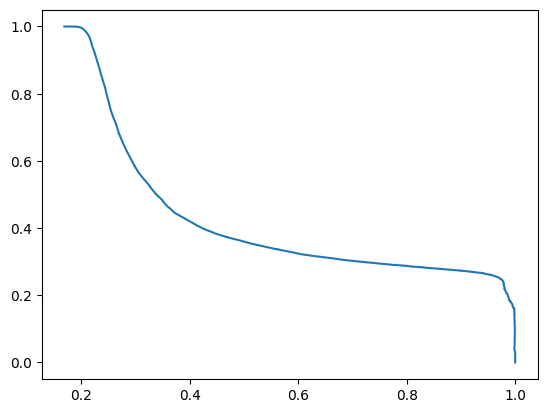

In [13]:
test.evaluate_model()

              precision    recall  f1-score   support

       False       0.87      1.00      0.93     90887
        True       0.97      0.25      0.40     18423

    accuracy                           0.87    109310
   macro avg       0.92      0.63      0.66    109310
weighted avg       0.89      0.87      0.84    109310



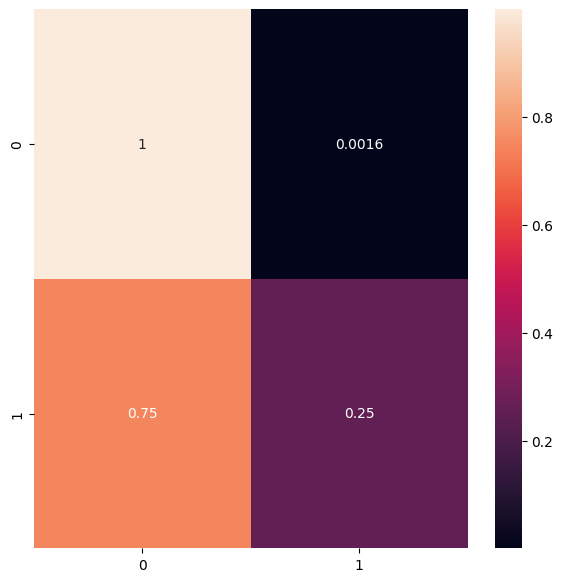

In [14]:
test.evaluate_model_metrics()